Library

In [1]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import torch.nn.functional as F
# from pytorch_lightning import seed_everything
# seed_everything(123)

Dataset

In [4]:
class AddPoissonNoise(object):
    def __init__(self, scale=255):
        """
        Initialize the AddPoissonNoise class.
        :param scale: The scale factor to adjust the intensity of the noise.
        """
        self.scale = scale

    def __call__(self, tensor):
        """
        Add Poisson noise to the tensor.
        :param tensor: Input tensor with values scaled between 0 and 1.
        :return: Tensor with Poisson noise added.
        """
        tensor_scaled = tensor * self.scale
        noise = torch.poisson(tensor_scaled) - tensor_scaled
        return (tensor + noise / self.scale).clamp(0, 1)

    def __repr__(self):
        return self.__class__.__name__ + '(scale={0})'.format(self.scale)
class AddSaltAndPepperNoise(object):
    def __init__(self, salt_pepper_ratio=0.5, amount=0.02):
        """
        Initialize the AddSaltAndPepperNoise class.
        :param salt_pepper_ratio: Ratio of salt (white) to pepper (black) noise.
        :param amount: Proportion of image pixels to replace with noise.
        """
        self.salt_pepper_ratio = salt_pepper_ratio
        self.amount = amount

    def __call__(self, tensor):
        """
        Add Salt and Pepper noise to the tensor.
        :param tensor: Input tensor.
        :return: Tensor with Salt and Pepper noise added.
        """
        noise = torch.rand_like(tensor)
        salt_pepper = torch.rand_like(tensor)

        # Add Salt noise
        noisy_tensor = torch.where((salt_pepper < self.amount * self.salt_pepper_ratio), torch.ones_like(tensor), tensor)

        # Add Pepper noise
        noisy_tensor = torch.where((salt_pepper < self.amount) & (salt_pepper >= self.amount * self.salt_pepper_ratio), torch.zeros_like(tensor), noisy_tensor)

        return noisy_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(salt_pepper_ratio={0}, amount={1})'.format(self.salt_pepper_ratio, self.amount)
class AddMultiplicativeNoise(object):
    def __init__(self, mean=1.0, std=0.1):
        """
        Initialize the AddMultiplicativeNoise class.
        :param mean: Mean of the multiplicative noise.
        :param std: Standard deviation of the multiplicative noise.
        """
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Add multiplicative noise to the tensor.
        :param tensor: Input tensor.
        :return: Tensor with multiplicative noise added.
        """
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor * noise

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
transform_test = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to Tensor
    AddMultiplicativeNoise() # Add Gaussian noise
])
transform_train = transforms.Compose([
    transforms.ToTensor() # Convert PIL image to Tensor   
])
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform_train
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform_test
)
test_data1 = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform_train
)

batch_size = 16

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)
test_dataloader1 = DataLoader(dataset=test_data1, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 800x800 with 0 Axes>

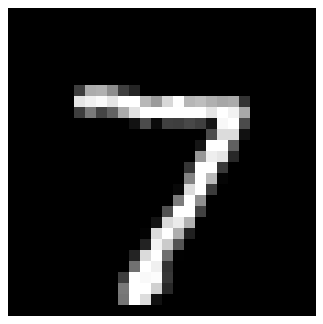

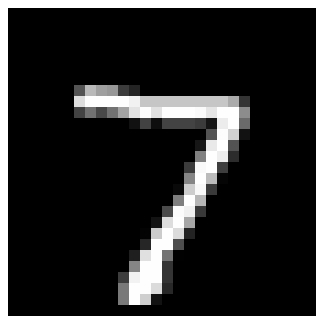

In [5]:
plt.figure(figsize=(8, 8))
iter_dataloader = iter(test_dataloader)

n=1

# 取出n*batch_size张图片可视化
for i in range(n):
    images, labels = next(iter_dataloader)
    image_grid = torchvision.utils.make_grid(images,nrow=4)
    plt.figure(figsize=(5, 5), dpi=80)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.savefig('MNIST_org_possion.pdf')
    plt.show()
iter_dataloader = iter(test_dataloader1)
for i in range(n):
    images, labels = next(iter_dataloader)
    # print(images)
    image_grid = torchvision.utils.make_grid(images,nrow=4)
    plt.figure(figsize=(5, 5), dpi=80)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.savefig('MNIST_noisy_possion.pdf')
    plt.show()

Model

In [4]:
class LeNet(nn.Module):
    def __init__(self, heatup = False):
        super(LeNet,self).__init__()
        self.heatup = heatup
        # self.dropout_scale = dropout_scale
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,stride=1,padding=1),
            nn.ReLU(),
            # nn.Dropout2d(p = dropout_scale),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            # nn.Dropout2d(p = dropout_scale),
            nn.MaxPool2d(2,2)
        )
        self.fc1 = nn.Linear(3136,200)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(200,10)


    def forward(self,x, test = False, temperature_train = 0, temperature_test = 0):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        if self.heatup:
            if test:
                mask = torch.rand_like(out) > torch.tensor(temperature_test)
                out = out.where(mask, -out)
            else:
                mask = torch.rand_like(out) > torch.tensor(temperature_train)
                out = out.where(mask, -out)
        out = self.fc2(out)
        return out

Train

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
def train(network, temperature = 0):
    # network = LeNet(dropout_scale=dropout_scale)
    network.train()
    losses = []
    iteration = 0
    epochs = 20
    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X, test = False, temperature_train = temperature)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        schduler.step()
        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss Value")
    # plt.plot(list(range(iteration)), losses)


# if os.path.exists('model.pth'):
#     network.load_state_dict(torch.load('model.pth'))
# else:


Test

In [6]:
def test(network, temperature = 0):
    positive = 0
    negative = 0
    network.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            pred = network(X, test= True, temperature_test = temperature)
            pred = F.softmax(pred, dim = 1)
            for item in zip(pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1
    acc = positive / (positive + negative)
    print(f"{acc * 100}%")
    return acc

Run

In [7]:
eps_train = [0,0.1,0.2,0.3,0.4]
eps_test =  [0]
# eps_train = [0.2]
# eps_test =  [0]
# eps_test = np.arange(0.2,0.4,0.01)
loss_fn = nn.CrossEntropyLoss()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
for I in eps_train:
    acc_list = []
    acc_adv_list = []
    success_rate_list = []
    network = LeNet(heatup=True)
    network.to(device)
    optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)
    schduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, np.arange(10,100,10), gamma=0.1)
    train(network, temperature=I)
    for J in eps_test:
        print(f"======dropout_train= {I} , dropout_test= {J} =======")
        acc_org = test(network,temperature=J)
        acc_list.append(acc_org)
        # 用对抗样本替代原始样本，测试准确度
        # 探究不同epsilon对LeNet分类准确度的影响
        positive = 0
        negative = 0
        # for epsilon in eps:
        epsilon = 0.25
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            X.requires_grad = True
            pred = network(X, test = True, temperature_test = J)
            network.zero_grad()
            loss = loss_fn(pred, y)
            loss.backward()
            X = X + epsilon * X.grad.sign()
            X_adv = torch.clamp(X, 0, 1)
            pred = network(X_adv, test = True, temperature_test = J)
            pred = F.softmax(pred, dim = 1)
            for item in zip(pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1

        acc_adv = positive / (positive + negative)
        acc_adv_list.append(acc_adv)
        attack_success_rate = acc_org - acc_adv
        success_rate_list.append(attack_success_rate)
        print(f"epsilon={epsilon} acc_org: {acc_org * 100}%  acc_adv: {acc_adv * 100}%  attack success rate:  {attack_success_rate * 100}%")
    ax1.plot(eps_test, acc_list, 'o-',label = 'train%.2f'%I)
    ax2.plot(eps_test, success_rate_list, 'o-',label = 'train%.2f'%I)
    ax3.plot(eps_test, acc_adv_list, 'o-', label = 'train%.2f'%I)
ax1.set_xlabel("Test temperature")
ax1.set_ylabel("Original test accuracy")
ax1.set_title('original test accuracy with test temperature')
ax1.legend()
ax2.set_xlabel("Test temperature")
ax2.set_ylabel("Atack success rate")
ax2.set_title('attack success rate with test temperature')
ax2.legend()
ax3.set_xlabel("Test temperature")
ax3.set_ylabel("Attack accuracy")
ax3.set_title('attack accuracy with test temperature')
ax3.legend()
plt.show()

Epoch 1 loss: 0.017982
Epoch 2 loss: 0.017603
Epoch 3 loss: 0.004178
Epoch 4 loss: 0.002002
Epoch 5 loss: 0.001357
Epoch 6 loss: 0.001019
Epoch 7 loss: 0.000809
Epoch 8 loss: 0.000684
Epoch 9 loss: 0.000597
Epoch 10 loss: 0.000532
Epoch 11 loss: 0.000430
Epoch 12 loss: 0.000412
Epoch 13 loss: 0.000404
Epoch 14 loss: 0.000398
Epoch 15 loss: 0.000393
Epoch 16 loss: 0.000388
Epoch 17 loss: 0.000383
Epoch 18 loss: 0.000378
Epoch 19 loss: 0.000374
Epoch 20 loss: 0.000369
======dropout_train= 0 , dropout_test= 0 =======
98.00999999999999%
epsilon=0.25 acc_org: 98.00999999999999%  acc_adv: 0.52%  attack success rate:  97.49%
Epoch 1 loss: 0.017974
Epoch 2 loss: 0.015956
Epoch 3 loss: 0.003901
Epoch 4 loss: 0.002639
Epoch 5 loss: 0.002058
Epoch 6 loss: 0.001659
Epoch 7 loss: 0.001388
Epoch 8 loss: 0.001192
Epoch 9 loss: 0.001059
Epoch 10 loss: 0.000937
Epoch 11 loss: 0.000812
Epoch 12 loss: 0.000768
Epoch 13 loss: 0.000756
Epoch 14 loss: 0.000763
Epoch 15 loss: 0.000753
Epoch 16 loss: 0.000735